In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image

2025-04-23 06:44:30.239638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745390670.488485      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745390670.556319      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import kagglehub
import os

# Download the dataset from KaggleHub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# Match GitHub structure by creating a new parent dir name
dataset_directory_location = os.path.join(path)
os.listdir(dataset_directory_location)

# GitHub-style train/test folder names (manually renamed or aliased from 'Training' and 'Testing')
train_dataset_location = os.path.join(dataset_directory_location, 'Training')  # or 'train' if renamed
test_dataset_location = os.path.join(dataset_directory_location, 'Testing')    # or 'test' if renamed

# Check the contents to confirm
if os.path.exists(train_dataset_location) and os.path.exists(test_dataset_location):
    print("✅ Train and Test Paths Exist")
    print("🧠 Train Classes:", os.listdir(train_dataset_location))
    print("🧠 Test Classes:", os.listdir(test_dataset_location))
else:
    raise FileNotFoundError("❌ Error: Train or Test path does not exist.")

✅ Train and Test Paths Exist
🧠 Train Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
🧠 Test Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [3]:
correct_image_shape = (224, 224, 3)

train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    train_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

test_image_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to your files
model_dir = "/kaggle/input"  # Change this if needed

vgg_model_path = f"{model_dir}/vgg19_model/keras/default/1/vgg19_model.keras"
inception_model_path = f"{model_dir}/inceptionv3_model/keras/default/1/inceptionv3_model.keras"
custom_model_path = f"/kaggle/input/custom_cnn_model/keras/default/1/custom_cnn_model.keras"
ensemble_model_path = f"{model_dir}/ensemble_model/keras/default/1/ensemble_model.keras"

# CSV paths (assuming you've exported JSON → CSV)
vgg_csv = "/kaggle/input/training-histories-csv/training_history_vgg.csv"
inception_csv = "/kaggle/input/training-histories-csv/training_history_incep.csv"
custom_csv = "/kaggle/input/training-histories-csv/training_history_custom.csv"
ensemble_csv = "/kaggle/input/training-histories-csv/training_history_ensem.csv"

# ✅ Load models (compile=False since we're only predicting)
vgg_model = load_model(vgg_model_path, compile=False)
inception_model = load_model(inception_model_path, compile=False)
custom_model = load_model(custom_model_path, compile=False)
ensemble_model = load_model(ensemble_model_path, compile=False)

# ✅ Load training histories
vgg_history = pd.read_csv(vgg_csv)
inception_history = pd.read_csv(inception_csv)
custom_history = pd.read_csv(custom_csv)
ensemble_history = pd.read_csv(ensemble_csv)

I0000 00:00:1745390972.246294      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745390972.247006      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
# ✅ Image dimensions
correct_image_shape = (224, 224, 3)

# ✅ Test data generator
test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"  # Update if needed
test_image_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important for matching predictions to true labels
)

# ✅ True labels and class names
y_true = test_image_gen.classes
class_names = list(test_image_gen.class_indices.keys())

def evaluate_model(model, model_name):
    print(f"🔍 Evaluating: {model_name}")

    # Predict on test data
    y_pred_proba = model.predict(test_image_gen, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Per-class precision, recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    x = np.arange(len(class_names))
    width = 0.25

    plt.figure(figsize=(10, 5))
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-score')
    plt.xticks(x, class_names, rotation=45)
    plt.title(f"Precision, Recall & F1 Score - {model_name}")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()

Found 1311 images belonging to 4 classes.


🔍 Evaluating: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745387015.248688     113 service.cc:148] XLA service 0x7d27fc006d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745387015.255073     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745387015.255098     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745387015.605721     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/82 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step 

I0000 00:00:1745387023.950050     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step
              precision    recall  f1-score   support

      glioma     0.9783    0.9033    0.9393       300
  meningioma     0.9200    0.9020    0.9109       306
     notumor     0.9758    0.9951    0.9853       405
   pituitary     0.9315    0.9967    0.9630       300

    accuracy                         0.9527      1311
   macro avg     0.9514    0.9493    0.9496      1311
weighted avg     0.9532    0.9527    0.9523      1311



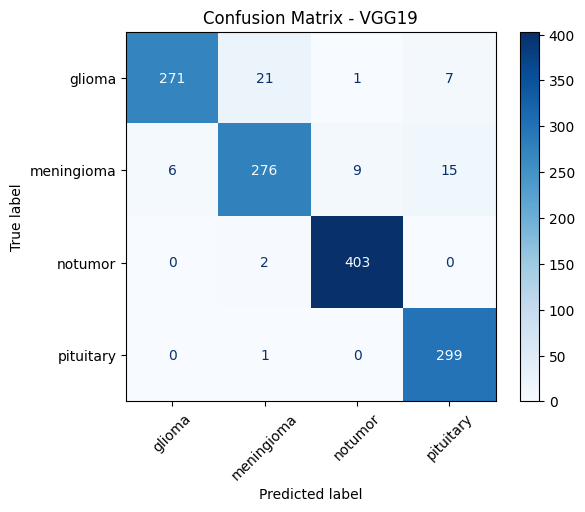

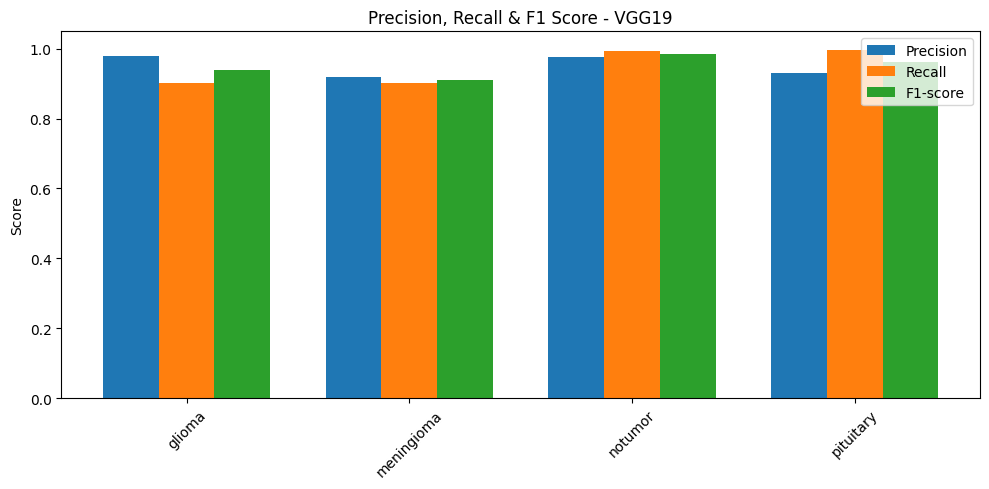

In [9]:
evaluate_model(vgg_model, "VGG19")

🔍 Evaluating: InceptionV3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745391020.692968     111 service.cc:148] XLA service 0x7ea578002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745391020.695930     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745391020.695955     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745391021.717641     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step  

I0000 00:00:1745391027.554641     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step
              precision    recall  f1-score   support

      glioma     0.9719    0.9233    0.9470       300
  meningioma     0.9304    0.9608    0.9453       306
     notumor     0.9975    1.0000    0.9988       405
   pituitary     0.9737    0.9867    0.9801       300

    accuracy                         0.9703      1311
   macro avg     0.9684    0.9677    0.9678      1311
weighted avg     0.9705    0.9703    0.9702      1311



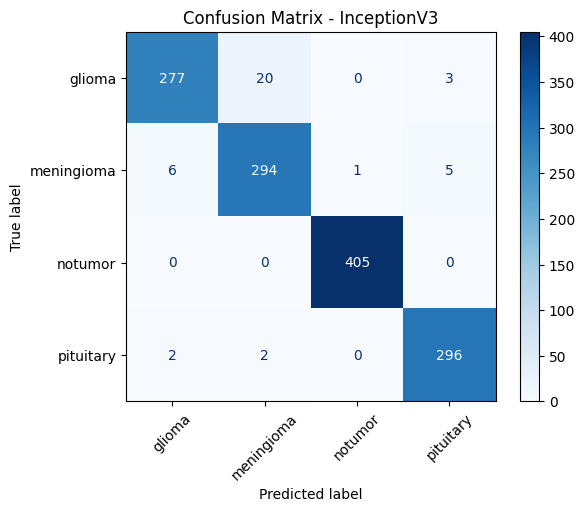

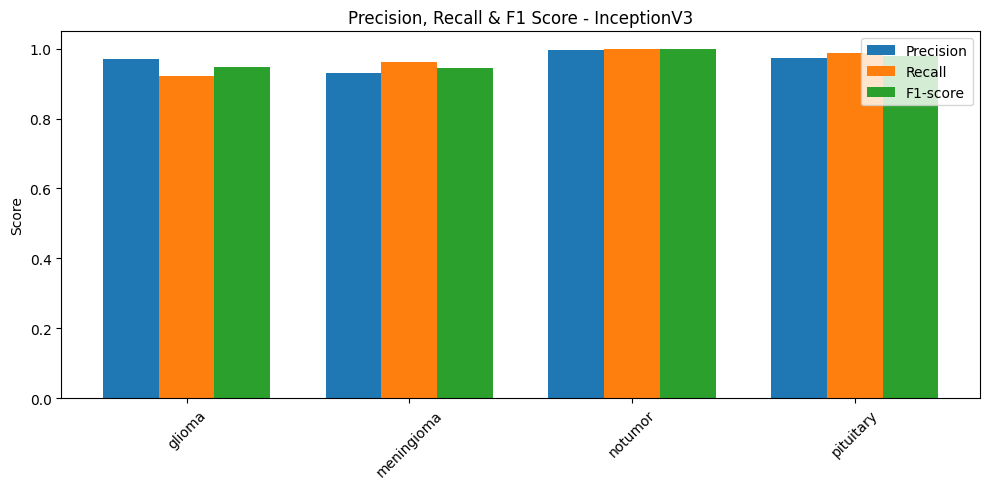

In [6]:
evaluate_model(inception_model, "InceptionV3")

🔍 Evaluating: Custom CNN
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step
              precision    recall  f1-score   support

      glioma     0.9065    0.8400    0.8720       300
  meningioma     0.8352    0.7451    0.7876       306
     notumor     0.9025    0.9827    0.9409       405
   pituitary     0.9216    0.9800    0.9499       300

    accuracy                         0.8940      1311
   macro avg     0.8914    0.8870    0.8876      1311
weighted avg     0.8921    0.8940    0.8914      1311



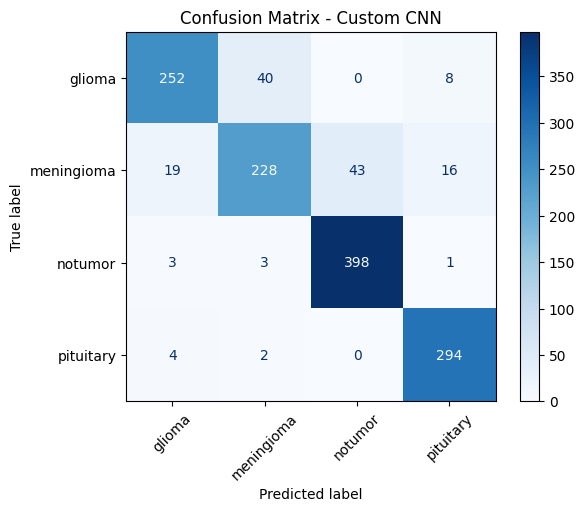

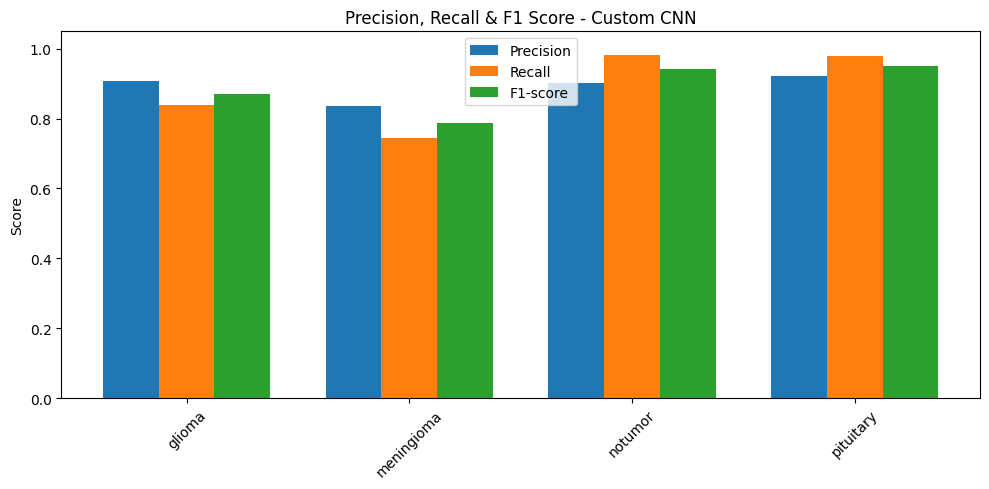

In [7]:
evaluate_model(custom_model, "Custom CNN")

🔍 Evaluating: Ensemble
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 354ms/step
              precision    recall  f1-score   support

      glioma     0.9896    0.9533    0.9711       300
  meningioma     0.9541    0.9510    0.9525       306
     notumor     0.9806    1.0000    0.9902       405
   pituitary     0.9836    0.9967    0.9901       300

    accuracy                         0.9771      1311
   macro avg     0.9770    0.9752    0.9760      1311
weighted avg     0.9772    0.9771    0.9770      1311



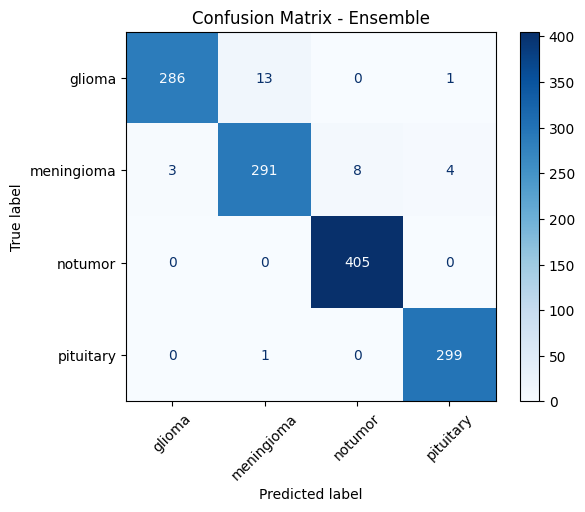

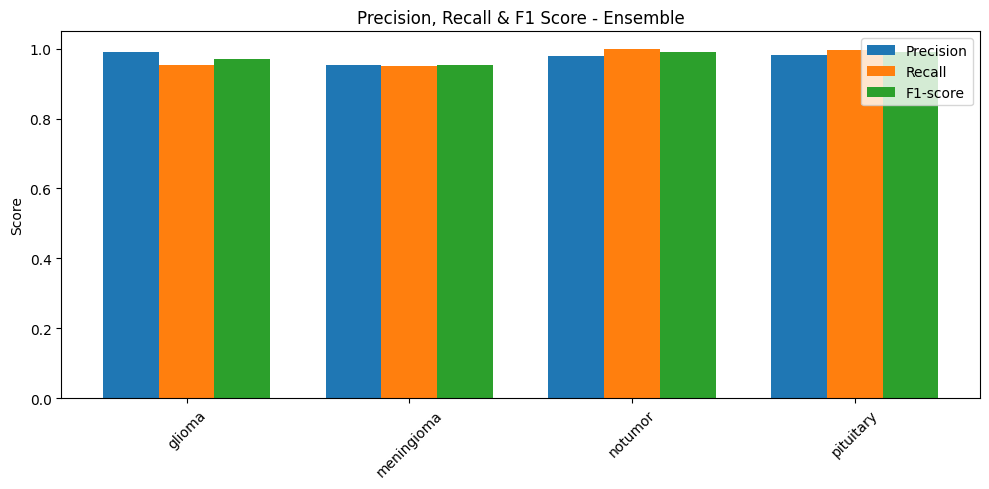

In [8]:
evaluate_model(ensemble_model, "Ensemble")